# "pytorch-widedeep, deep learning for tabular data II: advanced use"
> a flexible package to combine tabular data with text and images using wide and deep models.

- author: Javier Rodriguez
- toc: true 
- badges: true
- comments: true

This is the second of the two posts introducing `pytorch-widedeep`, a flexible package to combine tabular data with text and images. 

In the first post I described `pytorch-widedeep`'s data preprocessing utilities, the main components of a `WideDeep` model and a quick example to illustrate the basic use of the library. In this post I will use a series of example to dig deeper into the many options `pytorch-widedeep` offers as we build wide and deep models.

## 1. Binary classification with varying parameters

Let's start by using again the [adult census](http://archive.ics.uci.edu/ml/datasets/Adult) dataset. 

Before moving any further, let me emphasize that, as we go through the examples, one should not pay excessive (or any) attention to the loss or the metrics in the sense that the input parameters are not selected to obtain "state of the art", but to illustrate usability. 

A proper benchmarking exercise will be carried out in a future post. Having said that, and without further ado, let's start.

In [1]:
#collapse-hide
import pandas as pd
import numpy as np

adult = pd.read_csv("data/adult/adult.csv.zip")
adult.columns = [c.replace("-", "_") for c in adult.columns]
adult["income_label"] = (adult["income"].apply(lambda x: ">50K" in x)).astype(int)
adult.drop("income", axis=1, inplace=True)

for c in adult.columns:
    if adult[c].dtype == 'O':
        adult[c] = adult[c].apply(lambda x: "unknown" if x == "?" else x)
        adult[c] = adult[c].str.lower()

In [2]:
adult.head()

,age,workclass,fnlwgt,education,educational_num,marital_status,occupation,relationship,race,gender,capital_gain,capital_loss,hours_per_week,native_country,income_label
0,25,private,226802,11th,7,never-married,machine-op-inspct,own-child,black,male,0,0,40,united-states,0
1,38,private,89814,hs-grad,9,married-civ-spouse,farming-fishing,husband,white,male,0,0,50,united-states,0
2,28,local-gov,336951,assoc-acdm,12,married-civ-spouse,protective-serv,husband,white,male,0,0,40,united-states,1
3,44,private,160323,some-college,10,married-civ-spouse,machine-op-inspct,husband,black,male,7688,0,40,united-states,1
4,18,unknown,103497,some-college,10,never-married,unknown,own-child,white,female,0,0,30,united-states,0


if you read the first post you will be familiar with the code below:

In [3]:
import torch

from pytorch_widedeep.preprocessing import WidePreprocessor, DensePreprocessor
from pytorch_widedeep.initializers import KaimingNormal, XavierNormal
from pytorch_widedeep.callbacks import ModelCheckpoint, LRHistory, EarlyStopping
from pytorch_widedeep.metrics import Accuracy, Recall
from pytorch_widedeep.optim import RAdam
from pytorch_widedeep.models import Wide, DeepDense, WideDeep

wide_cols = ['education', 'relationship','workclass','occupation','native_country','gender']
crossed_cols = [('education', 'occupation'), ('native_country', 'occupation')]
cat_embed_cols = [('education',16), ('relationship',8), ('workclass',16), ('occupation',16),('native_country',16)]
continuous_cols = ["age","hours_per_week"]
target_col = 'income_label'

# TARGET
target = adult[target_col].values

# WIDE
preprocess_wide = WidePreprocessor(wide_cols=wide_cols, crossed_cols=crossed_cols)
X_wide = preprocess_wide.fit_transform(adult)

# DEEP
preprocess_deep = DensePreprocessor(embed_cols=cat_embed_cols, continuous_cols=continuous_cols)
X_deep = preprocess_deep.fit_transform(adult)

In [4]:
wide = Wide(wide_dim=np.unique(X_wide).shape[0], pred_dim=1)

# We can add dropout and batchnorm to the dense layers
deepdense = DeepDense(hidden_layers=[64,32], dropout=[0.5, 0.5], batchnorm=True,
                      deep_column_idx=preprocess_deep.deep_column_idx,
                      embed_input=preprocess_deep.embeddings_input,
                      continuous_cols=continuous_cols)

model = WideDeep(wide=wide, deepdense=deepdense)

Let's have a look to the model that we will be running:

In [5]:
model

WideDeep(
  (wide): Wide(
    (wide_linear): Embedding(797, 1, padding_idx=0)
  )
  (deepdense): Sequential(
    (0): DeepDense(
      (embed_layers): ModuleDict(
        (emb_layer_education): Embedding(17, 16)
        (emb_layer_native_country): Embedding(43, 16)
        (emb_layer_occupation): Embedding(16, 16)
        (emb_layer_relationship): Embedding(7, 8)
        (emb_layer_workclass): Embedding(10, 16)
      )
      (embed_dropout): Dropout(p=0.0, inplace=False)
      (dense): Sequential(
        (dense_layer_0): Sequential(
          (0): Linear(in_features=74, out_features=64, bias=True)
          (1): LeakyReLU(negative_slope=0.01, inplace=True)
          (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (3): Dropout(p=0.5, inplace=False)
        )
        (dense_layer_1): Sequential(
          (0): Linear(in_features=64, out_features=32, bias=True)
          (1): LeakyReLU(negative_slope=0.01, inplace=True)
          (2): BatchN

Now we will define the set up for each model component, including optimizers, learning rate schedulers and initializers:

In [6]:
# Optimizers
wide_opt = torch.optim.Adam(model.wide.parameters(), lr=0.03)
deep_opt = RAdam(model.deepdense.parameters(), lr=0.1)

# LR Schedulers
wide_sch = torch.optim.lr_scheduler.StepLR(wide_opt, step_size=3)
deep_sch = torch.optim.lr_scheduler.StepLR(deep_opt, step_size=5)

# Component-dependent settings as Dict
optimizers = {'wide': wide_opt, 'deepdense':deep_opt}
schedulers = {'wide': wide_sch, 'deepdense':deep_sch}
initializers = {'wide': KaimingNormal, 'deepdense':XavierNormal}

# General settings as List
callbacks = [LRHistory(n_epochs=10), EarlyStopping, ModelCheckpoint(filepath='model_weights/wd_out')]
metrics = [Accuracy, Recall]

Compile and fit!

In [7]:
model.compile(method='binary', optimizers=optimizers, lr_schedulers=schedulers, 
              initializers=initializers,
              callbacks=callbacks,
              metrics=metrics, 
              verbose=False)

In [8]:
model.fit(X_wide=X_wide, X_deep=X_deep, target=target, n_epochs=10, batch_size=256, val_split=0.2)

In [9]:
#collapse-hide
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

Text(0, 0.5, 'learning rate')

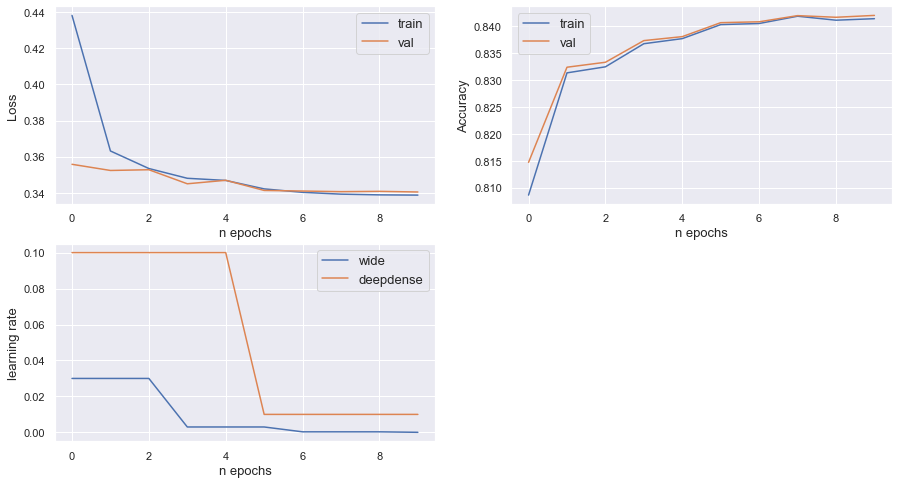

In [10]:
#collapse-hide
plt.figure(figsize=(15,8))
plt.subplot(2,2,1)
plt.plot(model.history._history['train_loss'], label="train")
plt.plot(model.history._history['val_loss'], label="val")
plt.legend(fontsize=13)
plt.xlabel("n epochs", fontsize=13)
plt.ylabel("Loss", fontsize=13)


plt.subplot(2,2,2)
plt.plot(model.history._history['train_acc'], label="train")
plt.plot(model.history._history['val_acc'], label="val")
plt.legend(fontsize=13)
plt.xlabel("n epochs", fontsize=13)
plt.ylabel("Accuracy", fontsize=13)

plt.subplot(2,2,3)
plt.plot(model.lr_history['lr_wide_0'], label="wide")
plt.plot(model.lr_history['lr_deepdense_0'], label="deepdense")
plt.legend(fontsize=13)
plt.xlabel("n epochs", fontsize=13)
plt.ylabel("learning rate", fontsize=13)

As we can see from the plots, the learning rate effectively decreases by a factor of 0.1 (the default) after the corresponding `step_size` for each component. Note that the keys in the `model.lr_history` dictionary have a suffix `_0`. This is because if you pass different parameter groups to the torch optimizers, these will also be recorded. We'll see this in the regression example, in the next section.

Before I move to the next section let me just mention that the `WideDeep` class comes with a useful method to "rescue" the learned embeddings, very creatively called `get_embeddings`. For example, let's say I want to use the embeddings learned for the different levels of the categorical feature `education`. These can be access via:

In [11]:
education_embed = model.get_embeddings(
    col_name='education', 
    cat_encoding_dict=preprocess_deep.label_encoder.encoding_dict
)
education_embed['doctorate']

array([ 0.23485082,  0.41219023,  0.12688892,  0.08351105, -0.29780635,
       -0.5321735 , -0.24137467, -0.49889308,  0.37074092, -0.11963069,
        0.7072009 ,  0.5613647 , -0.0930844 , -0.5126964 , -0.05072869,
       -0.40419328], dtype=float32)

## 2. Regression combining tabular, text and images

For this example we will use a small sample (so you can run it locally in a laptop) of the [Airbnb listings dataset](http://insideairbnb.com/get-the-data.html) in London. 

In case you are interested in all details, I did prepared the original dataset for this post, and all the code can be found at the `airbnb_data_preprocessing.py`, [here](`https://github.com/jrzaurin/pytorch-widedeep/blob/master/examples/airbnb_data_preprocessing.py`). After such preprocessing the data looks like this: 

In [12]:
#collapse-hide
airbnb = pd.read_csv('data/airbnb/airbnb_sample.csv')

In [13]:
airbnb.head(1)

,id,host_id,description,host_listings_count,host_identity_verified,neighbourhood_cleansed,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,guests_included,minimum_nights,instant_bookable,cancellation_policy,has_house_rules,host_gender,accommodates_catg,guests_included_catg,minimum_nights_catg,host_listings_count_catg,bathrooms_catg,bedrooms_catg,beds_catg,amenity_24-hour_check-in,amenity__toilet,amenity_accessible-height_bed,amenity_accessible-height_toilet,amenity_air_conditioning,amenity_air_purifier,amenity_alfresco_bathtub,amenity_amazon_echo,amenity_baby_bath,amenity_baby_monitor,amenity_babysitter_recommendations,amenity_balcony,amenity_bath_towel,amenity_bathroom_essentials,amenity_bathtub,amenity_bathtub_with_bath_chair,amenity_bbq_grill,amenity_beach_essentials,amenity_beach_view,amenity_beachfront,amenity_bed_linens,amenity_bedroom_comforts,...,amenity_roll-in_shower,amenity_room-darkening_shades,amenity_safety_card,amenity_sauna,amenity_self_check-in,amenity_shampoo,amenity_shared_gym,amenity_shared_hot_tub,amenity_shared_pool,amenity_shower_chair,amenity_single_level_home,amenity_ski-in_ski-out,amenity_smart_lock,amenity_smart_tv,amenity_smoke_detector,amenity_smoking_allowed,amenity_soaking_tub,amenity_sound_system,amenity_stair_gates,amenity_stand_alone_steam_shower,amenity_standing_valet,amenity_steam_oven,amenity_stove,amenity_suitable_for_events,amenity_sun_loungers,amenity_table_corner_guards,amenity_tennis_court,amenity_terrace,amenity_toilet_paper,amenity_touchless_faucets,amenity_tv,amenity_walk-in_shower,amenity_warming_drawer,amenity_washer,amenity_washer_dryer,amenity_waterfront,amenity_well-lit_path_to_entrance,amenity_wheelchair_accessible,amenity_wide_clearance_to_shower,amenity_wide_doorway_to_guest_bathroom,amenity_wide_entrance,amenity_wide_entrance_for_guests,amenity_wide_entryway,amenity_wide_hallways,amenity_wifi,amenity_window_guards,amenity_wine_cooler,security_deposit,extra_people,yield
0,13913.jpg,54730,My bright double bedroom with a large window has a relaxed feeling! It comfortably fits one or t...,4.0,f,Islington,51.56802,-0.11121,t,apartment,private_room,2,1.0,1.0,0.0,1,1,f,moderate,1,female,2,1,1,3,1,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,...,1,1,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,1,0,0,0,1,0,0,100.0,15.0,12.0


Let's define what will go through the wide and deep components

In [14]:
# wide
crossed_cols = (["property_type", "room_type"],)
already_dummies = [c for c in airbnb.columns if "amenity" in c] + ["has_house_rules"]
wide_cols = [
    "is_location_exact",
    "property_type",
    "room_type",
    "host_gender",
    "instant_bookable",
] + already_dummies

# deepdense
cat_embed_cols = [(c, 16) for c in airbnb.columns if "catg" in c] + [
    ("neighbourhood_cleansed", 64),
    ("cancellation_policy", 16),
]
continuous_cols = ["latitude", "longitude", "security_deposit", "extra_people"]
already_standard = ["latitude", "longitude"]

# deeptext (at this day and age you might want to use other word vectors...)
text_col = "description"
word_vectors_path = "data/glove.6B/glove.6B.100d.txt"

# deepimage
img_col = "id"
img_path = "data/airbnb/property_picture"

# target
target_col = "yield"

Note the following: columns that are already dummies (defined as `already_dummies`), are treated as any other wide column. Internally, nothing will really happen to them. They will just add one entry to the embedding lookup table. 

On the other hand, you will see that among the columns that will be passed through the `deepdense` component we have `already_standard` columns, which are longitude and latitude. These are columns for which it makes no sense to standardize them. However, at the same time, one would not advise to pass inputs to the network that are in a very different scale. Nonetheless, I decided to include a `already_standard` parameter in the `DensePreprocessor` and the columns passed as `already_standard` will not be normalized. 

In [15]:
import os
import torch

from pytorch_widedeep.preprocessing import WidePreprocessor, DensePreprocessor, TextPreprocessor, ImagePreprocessor
from pytorch_widedeep.models import Wide, DeepDense, DeepText, DeepImage, WideDeep
from pytorch_widedeep.initializers import *
from pytorch_widedeep.callbacks import *

In [16]:
target = airbnb[target_col].values

wide_preprocessor = WidePreprocessor(wide_cols=wide_cols, crossed_cols=crossed_cols)
X_wide = wide_preprocessor.fit_transform(airbnb)

deep_preprocessor = DensePreprocessor(embed_cols=cat_embed_cols, continuous_cols=continuous_cols,
    already_standard=already_standard)
X_deep = deep_preprocessor.fit_transform(airbnb)

text_preprocessor = TextPreprocessor(word_vectors_path=word_vectors_path, text_col=text_col)
X_text = text_preprocessor.fit_transform(airbnb)

image_preprocessor = ImagePreprocessor(img_col=img_col, img_path=img_path)
X_images = image_preprocessor.fit_transform(airbnb)

The vocabulary contains 2192 tokens
Indexing word vectors...
Loaded 400000 word vectors
Preparing embeddings matrix...
2175 words in the vocabulary had data/glove.6B/glove.6B.100d.txt vectors and appear more than 5 times
Reading Images from data/airbnb/property_picture


  4%|▍         | 40/1001 [00:00<00:02, 395.94it/s]

Resizing


100%|██████████| 1001/1001 [00:02<00:00, 392.30it/s]


Computing normalisation metrics


At this stage the data is ready to be passed through the model. However, instead of building a "simple" model that collects the `wide`, `deepdense`, `deeptext` and `deepimage` component, I am going to use this opportunity to illustrate `pytorch-widedepp`'s flexibility to build wide and deep models. I like to call this, getting into *Kaggle mode*.

First we define the components of the model...

In [17]:
wide = Wide(wide_dim=np.unique(X_wide).shape[0], pred_dim=1)

deepdense = DeepDense(hidden_layers=[128,64], dropout=[0.5, 0.5], 
                      deep_column_idx=deep_preprocessor.deep_column_idx,
                      embed_input=deep_preprocessor.embeddings_input,
                      continuous_cols=continuous_cols)

deeptext = DeepText(vocab_size=len(text_preprocessor.vocab.itos), hidden_dim=64, 
                    n_layers=2, rnn_dropout=0.5, 
                    embedding_matrix=text_preprocessor.embedding_matrix)

deepimage = DeepImage(pretrained=True, freeze=7, head_layers=[512, 256, 128])

...and, as we build the model, add a fully connected *head* via the input parameters (could also be used via the additional component/parameter `deephead`)

In [18]:
model = WideDeep(wide=wide, deepdense=deepdense, deeptext=deeptext, deepimage=deepimage, head_layers=[128, 64])

Let's have a look to the model

In [19]:
model

WideDeep(
  (wide): Wide(
    (wide_linear): Embedding(357, 1, padding_idx=0)
  )
  (deepdense): DeepDense(
    (embed_layers): ModuleDict(
      (emb_layer_accommodates_catg): Embedding(4, 16)
      (emb_layer_bathrooms_catg): Embedding(4, 16)
      (emb_layer_bedrooms_catg): Embedding(5, 16)
      (emb_layer_beds_catg): Embedding(5, 16)
      (emb_layer_cancellation_policy): Embedding(6, 16)
      (emb_layer_guests_included_catg): Embedding(4, 16)
      (emb_layer_host_listings_count_catg): Embedding(5, 16)
      (emb_layer_minimum_nights_catg): Embedding(4, 16)
      (emb_layer_neighbourhood_cleansed): Embedding(33, 64)
    )
    (embed_dropout): Dropout(p=0.0, inplace=False)
    (dense): Sequential(
      (dense_layer_0): Sequential(
        (0): Linear(in_features=196, out_features=128, bias=True)
        (1): LeakyReLU(negative_slope=0.01, inplace=True)
        (2): Dropout(p=0.5, inplace=False)
      )
      (dense_layer_1): Sequential(
        (0): Linear(in_features=128, out_f

This is a big model, so let me go component by component. 

1. `wide`: simple linear model implemented via an `Embedding` layer

2. `deepdense`: embeddings concatenated to categorical columns that are then passed through two dense layers with the following sizes [196 $\rightarrow$ 128 $\rightarrow$ 64]. 

3. `deeptext`: two stacked LTSMs that will received the pre-trained glove wordvectors and output a last hidden state of dim 64 (this would be 128 if we had used `bidirectional = True`)

4. `deepimage`: a pre-trained ResNet 18 model where only the last `Sequential` block (7) will be trained. The rest will remain "frozen". on top of it we have `imagehead` which is just a `Sequential` model comprised of two dense layers with the following sizes [512 $\rightarrow$ 256 $\rightarrow$ 128]

5. `deephead`: on top of the 3 deep components we have a final component referred as `deephead` (this would correspond to the `architecture 2` described in the first post). This component will receive the concatenated output from all the deep components, and pass it through a further collection of dense layers. In this case the sizes are [256 $\rightarrow$ 64 $\rightarrow$ 1]. We input 256 because the output dim from `deepdense` is 64, the  output dim from `deeptext` is 64 and the output dim from `deeptext` is 128. The final `deephead` output dim is 1 because we are performing a regression, i.e. one output neuron with no activation function. 

Let's go even a step further and use different optimizers, initializers and schedulers for different components. Moreover, let's use a different learning rate for different parameter groups in the case of the `deepdense`, remember, this is *Kaggle mode*.

In [20]:
# Optimizers. Different parameter groups for the deepdense component will use different lr
deep_params = []
for childname, child in model.named_children():
    if childname == 'deepdense':
        for n,p in child.named_parameters():
            if "emb_layer" in n: deep_params.append({'params': p, 'lr': 0.01})
            else: deep_params.append({'params': p, 'lr': 0.03})
                
wide_opt = torch.optim.Adam(model.wide.parameters(), lr=0.03)
deep_opt = torch.optim.Adam(deep_params)
text_opt = RAdam(model.deeptext.parameters())
img_opt  = RAdam(model.deepimage.parameters())
head_opt = torch.optim.AdamW(model.deephead.parameters())
optimizers = {'wide': wide_opt, 'deepdense':deep_opt, 'deeptext':text_opt, 'deepimage': img_opt, 'deephead': head_opt}

# schedulers
wide_sch = torch.optim.lr_scheduler.StepLR(wide_opt, step_size=5)
deep_sch = torch.optim.lr_scheduler.MultiStepLR(deep_opt, milestones=[3,8])
text_sch = torch.optim.lr_scheduler.StepLR(text_opt, step_size=5)
img_sch  = torch.optim.lr_scheduler.MultiStepLR(deep_opt, milestones=[3,8])
head_sch = torch.optim.lr_scheduler.StepLR(head_opt, step_size=5)
schedulers = {'wide': wide_sch, 'deepdense':deep_sch, 'deeptext':text_sch, 'deepimage': img_sch, 'deephead': head_sch}

# initializers
initializers = {'wide': KaimingNormal, 'deepdense':KaimingNormal, 
                'deeptext':KaimingNormal(pattern=r"^(?!.*word_embed).*$"), # do not initialize the pre-trained word-vectors!
                'deepimage':KaimingNormal}

# transforms and callbacks
mean = [0.406, 0.456, 0.485]  #BGR
std =  [0.225, 0.224, 0.229]  #BGR
transforms = [ToTensor, Normalize(mean=mean, std=std)]
callbacks = [LRHistory(n_epochs=10), EarlyStopping, ModelCheckpoint(filepath='model_weights/wd_out')]                

Note that, since we will use pre-trained word embeddings, we do not want to initialize these embeddings. However you might still want to initialize the other layers in the `deeptext` component. This is not a problem, you can do that with the parameter `pattern` and your knowledge on regular  expressions. In the `deeptext` initializer definition above:

```python
KaimingNormal(pattern=r"^(?!.*word_embed).*$")
```

I am NOT initializing parameters whose name contains the string `word_embed`. 

So...let's compile and run, which is as easy as:

In [21]:
model.compile(method='regression', initializers=initializers, optimizers=optimizers,
    lr_schedulers=schedulers, callbacks=callbacks, transforms=transforms)

model.fit(X_wide=X_wide, X_deep=X_deep, X_text=X_text, X_img=X_images,
    target=target, n_epochs=1, batch_size=32, val_split=0.2)

  0%|          | 0/25 [00:00<?, ?it/s]

Training


valid: 100%|██████████| 7/7 [00:15<00:00,  2.26s/it, loss=1.24e+4]


As I mentioned early in the post, please, do not focus on the success metric/loss (`mse` in this case). I am just using a very small sample of the dataset and some "random" set up. I just want to illustrate usability. A benchmark post will come in the "no-so-distant future".

## 3. Warm up routines

When running `.fit`, we can choose to first "warm up" each model individually (similarly to fine-tunning if the model was pre-trained, but this is a general functionality, i.e. there is no need of a pre-trained model) before the joined training begins.

`pytorch-widedeep` implements 3 different warming up routines:

1. Warm up all trainable layers at once with a triangular one-cycle learning rate (referred as slanted triangular learning rates in [Howard & Ruder 2018](https://arxiv.org/abs/1801.06146) [1]). See [here](https://github.com/jrzaurin/pytorch-widedeep/blob/master/examples/06_WarmUp_Model_Components.ipynb) for an example on this routine for a simpler `wide` + `deepdense` model. 

2. Gradual warm up *inspired* by the work of [Felbo et al., 2017](https://arxiv.org/abs/1708.00524) [2] for fine-tunning

3. Gradual warm up *inspired* by the work of [Howard & Ruder 2018](https://arxiv.org/abs/1801.06146) for fine-tunning

Currently warming up is only supported without a fully connected `deephead`, i.e. if `deephead=None`. In addition, Felbo and Howard routines only applied to the `deeptext` and `deepimage` components. The `wide` and `deepdense` components can also be warmed up, but together, following the first of the 3 routines described before.

Let me briefly describe the "Felbo" and "Howard" routines before showing how to use them.

### 3.1 The Felbo warm-up routine

The Felbo warm-up routine can be illustrated by the following figure:

<img src="figures/pytorch-widedeep/felbo_routine.png" alt="resnet_block" width="500"/>

**Figure 1**. The process in the figure can be described as follows: warm up (or train) the last layer for one epoch using a one cycle triangular learning rate. Then warm up the next deeper layer for one epoch, with a learning rate that is a factor of 2.5 lower than the previous learning rate (the 2.5 factor is fixed) while freezing the already warmed up layer(s). Repeat untill all individual layers are warmed. Then warm one last epoch with all warmed layers trainable. The vanishing color gradient in the figure attempts to illustrate the decreasing learning rate.

Note that this is not identical to the Fine-Tunning routine described in Felbo et al, 2017, this is why I used the word '*inspired*' before.

### 3.1 The Howard warm-up routine

The Howard routine can be illustrated by the following figure:

<img src="figures/pytorch-widedeep/howard_routine.png" alt="resnet_block" width="500"/>

**Figure 2**. The process in the figure can be described as follows: warm up (or train) the last layer for one epoch using a one cycle triangular learning rate. Then warm up the next deeper layer for one epoch, with a learning rate that is a factor of 2.5 lower than the previous learning rate (the 2.5 factor is fixed) while keeping the already warmed up layer(s) trainable. Repeat. The vanishing color gradient in the figure attempts to illustrate the decreasing learning rate.

Note that I write "*warm up (or train) the last layer for one epoch [...]*". However, in practice the user will have to specify the order of the layers to be warmed up. This is another reason why I wrote that the warm up routines I have implemented are inspired by the work of Felbo and Howard and not identical to their implemenations.

The felbo and howard routines can be accessed with via the [warm up parameters](https://pytorch-widedeep.readthedocs.io/en/latest/wide_deep.html#pytorch_widedeep.models.wide_deep.WideDeep.fit). Let's have a look:

In [23]:
wide = Wide(wide_dim=np.unique(X_wide).shape[0], pred_dim=1)
deepdense = DeepDense( hidden_layers=[64,32], dropout=[0.2,0.2],
                      deep_column_idx=deep_preprocessor.deep_column_idx,
                      embed_input=deep_preprocessor.embeddings_input,
                      continuous_cols=continuous_cols)
deeptext = DeepText(vocab_size=len(text_preprocessor.vocab.itos),
                    hidden_dim=64, n_layers=3, rnn_dropout=0.5,
                    embedding_matrix=text_preprocessor.embedding_matrix)
deepimage = DeepImage(pretrained=True, head_layers=None)
model = WideDeep(wide=wide, deepdense=deepdense, deeptext=deeptext, deepimage=deepimage)
model.compile(method='regression')

This is a similar model to the one before but without the final `deephead`. There, we saw that the `deepimage` component, identical to the one discussed here, is comprised by a Sequential model that is a ResNet backbone and a Linear Layer. 

In this example, I warm up the layers in the ResNet backbone, apart from the first sequence `[Conv2d -> BatchNorm2d -> ReLU -> MaxPool2d]`, and the Linear layer. 

This is done as follows:

In [24]:
first_child = list(model.deepimage.children())[0]
img_layers = list(first_child.backbone.children())[4:8] + [list(model.deepimage.children())[1]]

In [25]:
warm_img_layers = img_layers[::-1]

In [26]:
model.fit(
    X_wide=X_wide, 
    X_deep=X_deep, 
    X_text=X_text, 
    X_img=X_images, 
    target=target, 
    n_epochs=1, 
    batch_size=32, 
    val_split=0.2, 
    warm_up=True, 
    warm_epochs=1, 
    warm_deepimage_gradual=True, 
    warm_deepimage_layers=warm_img_layers, 
    warm_deepimage_max_lr=0.01, 
    warm_routine='howard'
)

  0%|          | 0/25 [00:00<?, ?it/s]

Warming up wide for 1 epochs


  0%|          | 0/25 [00:00<?, ?it/s]

Warming up deepdense for 1 epochs


  0%|          | 0/25 [00:00<?, ?it/s]

Warming up deeptext for 1 epochs


  0%|          | 0/25 [00:00<?, ?it/s]

Warming up deepimage, layer 1 of 5


  0%|          | 0/25 [00:00<?, ?it/s]

Warming up deepimage, layer 2 of 5


  0%|          | 0/25 [00:00<?, ?it/s]

Warming up deepimage, layer 3 of 5


  0%|          | 0/25 [00:00<?, ?it/s]

Warming up deepimage, layer 4 of 5


  0%|          | 0/25 [00:00<?, ?it/s]

Warming up deepimage, layer 5 of 5


  0%|          | 0/25 [00:00<?, ?it/s]

Training


valid: 100%|██████████| 7/7 [00:16<00:00,  2.43s/it, loss=1.4e+4] 


## 4. Custom model

So far we have used the components that come with `pytorch-widedee`. However, as I mentioned in the first post, it is very likely that the user wants to use custom models for the `deeptext` and `deepimage` components. This is easily attainable by...well...simply passing your own model. 

You should just remember that the model must return the last layer of activations (and NOT the predictions) and must contained an attribute called `output_dim` with the output dimension of  that last layer. 

For example, let's say we want to use as `deeptext` a **very** simple stack of 2 bidirectional GRUs.

In [27]:
from torch import nn


class MyDeepText(nn.Module):
    def __init__(self, vocab_size, padding_idx=1, embed_dim=100, hidden_dim=64):
        super(MyDeepText, self).__init__()

        # word/token embeddings
        self.word_embed = nn.Embedding(
            vocab_size, embed_dim, padding_idx=padding_idx
        )

        # stack of RNNs
        self.rnn = nn.GRU(
            embed_dim,
            hidden_dim,
            num_layers=2,
            bidirectional=True,
            batch_first=True,
        )

        # Remember, this must be defined. If not WideDeep will through an error
        self.output_dim = hidden_dim * 2

    def forward(self, X):
        embed = self.word_embed(X.long())
        o, h = self.rnn(embed)
        return torch.cat((h[-2], h[-1]), dim=1)

And from here, "*proceed as usual*"

In [28]:
wide = Wide(wide_dim=np.unique(X_wide).shape[0], pred_dim=1)
deepdense = DeepDense( hidden_layers=[64,32], dropout=[0.2,0.2],
                      deep_column_idx=deep_preprocessor.deep_column_idx,
                      embed_input=deep_preprocessor.embeddings_input,
                      continuous_cols=continuous_cols)
mydeeptext = MyDeepText(vocab_size=len(text_preprocessor.vocab.itos))
model = WideDeep(wide=wide, deepdense=deepdense, deeptext=mydeeptext)
model.compile(method='regression')

In [29]:
model

WideDeep(
  (wide): Wide(
    (wide_linear): Embedding(357, 1, padding_idx=0)
  )
  (deepdense): Sequential(
    (0): DeepDense(
      (embed_layers): ModuleDict(
        (emb_layer_accommodates_catg): Embedding(4, 16)
        (emb_layer_bathrooms_catg): Embedding(4, 16)
        (emb_layer_bedrooms_catg): Embedding(5, 16)
        (emb_layer_beds_catg): Embedding(5, 16)
        (emb_layer_cancellation_policy): Embedding(6, 16)
        (emb_layer_guests_included_catg): Embedding(4, 16)
        (emb_layer_host_listings_count_catg): Embedding(5, 16)
        (emb_layer_minimum_nights_catg): Embedding(4, 16)
        (emb_layer_neighbourhood_cleansed): Embedding(33, 64)
      )
      (embed_dropout): Dropout(p=0.0, inplace=False)
      (dense): Sequential(
        (dense_layer_0): Sequential(
          (0): Linear(in_features=196, out_features=64, bias=True)
          (1): LeakyReLU(negative_slope=0.01, inplace=True)
          (2): Dropout(p=0.2, inplace=False)
        )
        (dense_layer_

In [30]:
model.fit(X_wide=X_wide, X_deep=X_deep, X_text=X_text, target=target, n_epochs=1, batch_size=32, val_split=0.2)

  0%|          | 0/25 [00:00<?, ?it/s]

Training


valid: 100%|██████████| 7/7 [00:00<00:00, 21.47it/s, loss=9.35e+3]


## 5. Conclusion

In this second post I tried to illustrate in detail the different functionalities of the `pytorch-widedeep` package, and how these can be used to customize each of the four potential components of the `WideDeep` model that can be built with `pytorch-widedeep`. I have also describe the warm-up routines that can be used to "warm-up" each individual component before the joined training and finally, how custom models, "external" to `pytorch-widedeep` can be used in combination with the package. 

However, this is not the end of the journey. As you will have seen, there is an "*imbalance in the `pytorch-widedeep` force*", in the sense that while fully pre-trained models are incorporated for the `deepimage` component, this is not the case for the `deeptext` component, where only pre-trained word embeddings are considered. Of course, as illusttrated in Section 4, you could build your own pre-trained `deeptext` component and pass it to the `WideDeep` constructor class, but eventually, I want to allow that option within the package. 

This means that eventually I will need to integrate the library with some of the pre-trained Language models available or simply code a custom version for `pytorch-widedeep`.

One the other hand, if there is one Deep Learning for Tabular data implementation that is becoming more and more popular is [TabNet](). There is already a fantastic [`Pytorch` implementation](https://github.com/dreamquark-ai/tabnet) which I highly recommend. I believe I could adapt that implementation to `pytorch-widedeep` and offer it as a deep component or on its own, like any other model component. 

I am pretty sure I will think of a few more things along the way. 

If you made it this far, thanks for reading! And if you use the package, let me know your thoughts!

#### References

[1] Universal Language Model Fine-tuning for Text Classification. Jeremy Howard, Sebastian Ruder, 2018 [arXiv:1801.06146v5](https://arxiv.org/abs/1801.06146)

[2] Using millions of emoji occurrences to learn any-domain representations for detecting sentiment, emotion and sarcasm. Bjarke Felbo, Alan Mislove, Anders Søgaard, et al., 2017. [arXiv:1708.00524](https://arxiv.org/abs/1708.00524)